In [60]:
import os

import pandas as pd
import numpy as np

import sys

import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression




import warnings
warnings.filterwarnings("ignore")




In [61]:
approved_statuses = ['Approved',
                     'Contracts Back',
                     'Contract Sent',
                     'Soft Approval',
                     'Ready to Fund',
                     'Lost Deal',
                     'Contract Returned',
                     'Funding Call',
                     'Open Approval']
declined_statuses = ['Negative Balances',
                     'Declined',
                     'Bad Credit',
                     'Too Small',
                     'No Room',
                     'Previous Default',
                     'Merchant Declined',
                     'Declined Previously',
                     'Too Few Deposits',
                     'SIC Code',
                     'Declined Bad Iso',
                     'Suspected Fraud',
                     'Auto-declined',
                     'Fraud',
                     'Missing Stips',
                     'Merchant Declined',
                     'No Logins',
                     'No COJ',
                     'Negative Banks',
                     'New MCA',
                     'Poor Landlord',
                     'Contracts Back Declined']
funded_statuses = ['Funded']

In [62]:
def status_groups(g):
    if g in approved_statuses:
        return "approved"
    elif g in declined_statuses:
        return "declined"
    elif g in funded_statuses:
        return "funded"
    else:
        return "still in submission"




In [63]:
def file_import(filename):
    df = pd.read_excel(filename,
                       parse_dates=True,
                       usecols="A:G,K")
    df = df.set_index(df.created_at)
    df['group_status'] = df['status'].apply(status_groups)
    df.loc[(df["group_status"].isin(["still in submission","declined"])) & (df["funded_amount"]!=0),"funded_amount"] = 0
    df.loc[(df["funded_amount"]>0) & (df["funded_amount"]<3000), "funded_amount"].apply(lambda x: x*1000)
    return df

def report_maker(filename):
    df = file_import(filename)
    df = df.set_index(df.created_at)
    df['group_status'] = df['status'].apply(status_groups)
    df.loc[(df["funded_amount"]>0) & (df["funded_amount"]<3000), "funded_amount"].apply(lambda x: x*1000)
    df.loc[(df["group_status"].isin(["still in submission","declined"])) & (df["funded_amount"]!=0),"funded_amount"] = 0
    month_counts = df.groupby([pd.Grouper(freq="M"), "group_status"])["funded_amount"].agg(["count","sum","mean"])
    month_counts["pct_of_total_submissions"] = df.groupby([pd.Grouper(freq="M"), "group_status"])["funded_amount"].agg(["count"]).groupby(level=0).apply(lambda x: x/float(x.sum()))
    month_counts = month_counts.unstack()
    for x in month_counts["count"].columns:
        if x != "still in submission":
            month_counts["count " + str(x) + " pct_ch"] = month_counts["count"][x].pct_change()
    for x in month_counts["sum"].columns:
        if x != "still in submission":
            month_counts["sum " + str(x) + " pct_ch"] = month_counts["sum"][x].pct_change()
    month_groups = df.groupby([pd.Grouper(freq='M')])["funded_amount"].agg(["count","sum"])
    month_groups["Mean Approved Amount"] = df[(df["group_status"].isin(["approved","funded"]) & (df["funded_amount"]>=3000))]["funded_amount"].groupby([pd.Grouper(freq='M')]).agg("mean")
    month_groups["count_pct_ch"] = df.groupby(pd.Grouper(freq="M"))["id"].count().pct_change()
    month_groups["sum_pct_ch"] = df.groupby(pd.Grouper(freq="M"))["funded_amount"].sum().pct_change()
    month_groups.columns = ["Total Submissions","Total Approved and Funded","Mean Approved Amount","Total Submissions Percent Change","Total Approved and Funded Percent Change"]
    combined_df = pd.concat([month_counts,month_groups],axis=1)
    combined_df.columns = ["Approved Count",
                       "Declined Count",
                       "Funded Count",
                       "Still in Submission Count",
                       "Sum of Open Approvals",
                       "Sum of Declined Approvals (drop)",
                       "Sum of Funded Deals",
                       "Sum of Still in Submission Deals (drop)",
                       "Average Approval (drop)",
                       "Average Declined (drop)",
                       "Average Funded Amount",
                       "Average Submission (drop)",
                       "Approved Percent of Total Submissions",
                       "Declined Percent of Total Submissions",
                       "Funded Percent of Total Submissions",
                       "Still in Submission Percent of Total Submissions",
                       'Total Approved Percent Change',
                       'Total Declined Percent Change',
                       'Total Funded Percent Change',
                       'Sum Open Approvals Percent Change',
                       'Sum Declined Percent Change (drop)',
                       'Sum Funded Percent Change',
                       'Total Submissions',
                       'Total Approved and Funded',
                       'Average Approval Amount',
                       'Total Submissions Percent Change',
                       'Total Approved and Funded Percent Change']
    for z in combined_df.columns:
        if "(drop)" in z:
            combined_df = combined_df.drop(z,axis=1)
    cols = combined_df.columns.tolist()
    cols = [cols[16], # 16 Total Submissions
            cols[19], # 19 Total Submissions Percent Change
            cols[17], # 17 Total Approved and Funded
            cols[20], # 20 Total Approved and Funded Percent Change
            cols[5],  # 5  Sum of Funded Deals
            cols[6],  # 6  Average Funded Amount
            cols[15], # 15 Sum Funded Percent Change
            cols[4],  # 4  Sum of Open Approvals
            cols[18], # 18 Average Approval Amount
            cols[14], # 14 Sum Open Approvals Percent Change
            cols[3],  # 3  Still in Submission Count
            cols[10], # 10 Still in Submission Percent of Total Submissions
            cols[0],  # 0  Approved Count
            cols[11], # 11 Total Approved Percent Change
            cols[7],  # 7  Approved Percent of Total Submissions
            cols[2],  # 2  Funded Count
            cols[13], # 13 Total Funded Percent Change
            cols[9],  # 9  Funded Percent of Total Submissions
            cols[1],  # 1  Declined Count
            cols[12], # 12 Total Declined Percent Change
            cols[8]]  # 8  Declined Percent of Total Submissions
    
    combined_df = combined_df[cols]
    
    stacked_uw_group_status_breakdown = df.groupby(['underwriter','group_status'])['id'].count().unstack(fill_value=0).T
    stacked_uw_status_breakdown = df.groupby(['underwriter','status'])['id'].count().unstack(fill_value=0).T

    def group_uw_by_status(df):
        df["Total"] = [df.T[x].sum() for x in df.T.columns]
        df = df.T
        df["Total"] = [df.T[x].sum() for x in df.T.columns]
        return df
    
    writer = pd.ExcelWriter(str(filename) + " ISO_Report.xlsx", engine="xlsxwriter")
    combined_df.to_excel(writer, sheet_name="Report")
    group_uw_by_status(stacked_uw_status_breakdown).to_excel(writer, sheet_name="UW_Status_Report")
    group_uw_by_status(stacked_uw_group_status_breakdown).to_excel(writer, sheet_name="UW_Group_Status_Report")
    writer.save()
    
    return combined_df




# volume_by_funded_amount = df.loc[(df.funded_amount>=3000) & (df.monthly_volume>0),["monthly_volume","funded_amount"]]
# X = volume_by_funded_amount.iloc[:,0].values.reshape(-1, 1)
# Y = volume_by_funded_amount.iloc[:,1].values.reshape(-1, 1)
# linear_regressor = LinearRegression()
# linear_regressor.fit(X,Y)
# Y_pred = linear_regressor.predict(X)

# volume_by_funded_amount.plot(kind='scatter',x='monthly_volume',y='funded_amount')
# plt.plot(X,Y_pred,color='red')
# plt.grid(True)

# plt.show()

# print(volume_by_funded_amount.corr())

# #To retrieve the intercept:
# print(linear_regressor.intercept_)
# #For retrieving the slope:
# print(linear_regressor.coef_)

In [64]:
def stacked_bar_chart(report):
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111)
    
    p1 = plt.bar(report.index, report["Still in Submission Percent of Total Submissions"],color="turquoise", width=1, align='center')
    p2 = plt.bar(report.index, report["Declined Percent of Total Submissions"],bottom=report["Still in Submission Percent of Total Submissions"], color="red", width=1, align='center')
    p3 = plt.bar(report.index, report["Approved Percent of Total Submissions"], bottom=report["Still in Submission Percent of Total Submissions"] + report["Declined Percent of Total Submissions"], color="orange", width=1, align='center')
    p4 = plt.bar(report.index, report["Funded Percent of Total Submissions"],bottom=report["Still in Submission Percent of Total Submissions"] + report["Declined Percent of Total Submissions"] + report["Approved Percent of Total Submissions"], color="green", width=1, align='center')
    
    plt.ylabel("% of Total Submissions", fontsize=16)
    plt.xlabel("Month", fontsize=16)
    plt.title("Total Submissions (%) by Month 2019 YTD", fontsize=16)
    plt.xticks(report.index, report.index.strftime("%b"), fontsize=16)
    plt.yticks(np.arange(0,11)/10,["{:.0%}".format(x) for x in np.arange(0,11)/10], fontsize=16)
    plt.legend((p4[0],p3[0],p2[0],p1[0]), ("Funded","Approved","Declined","Still in Submissions"), fontsize=16)
    
    for r1, r2, r3, r4 in zip(p1,p2,p3,p4):
        h1,h2,h3,h4 = r1.get_height(), r2.get_height(), r3.get_height(), r4.get_height()
        plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "{:.1%}".format(h1), ha="center", va="center", color="white", fontsize=16, fontweight="bold")
        plt.text(r2.get_x() + r2.get_width() / 2., h1+h2 / 2., "{:.1%}".format(h2), ha="center", va="center", color="white", fontsize=16, fontweight="bold")
        plt.text(r3.get_x() + r3.get_width() / 2., h1+h2+h3 / 2., "{:.1%}".format(h3), ha="center", va="center", color="white", fontsize=16, fontweight="bold")
        plt.text(r4.get_x() + r4.get_width() / 2., h1+h2+h3+h4 / 2., "{:.1%}".format(h4), ha="center", va="center", color="white", fontsize=16, fontweight="bold")
    plt.savefig('total_submissions_by_month.jpeg')
    print("Image File Generated: total_submissions_by_month.jpeg")

In [65]:
def corr_plot(report):
    correlation_data = report.iloc[:,[0,4,7,2,5,8,10,12,15,18]]
    corr = correlation_data.corr()
    fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches

    fig = sns.heatmap(corr, annot=True, ax=ax)
    plt.tight_layout()
    ax.set_ylim(bottom=10, top=0)
    plt.savefig("correlation_plot.jpeg")
    print("Image File Generated: correlation_plot.jpeg")

In [66]:
def counts_and_amounts(report):
    fig = plt.figure(figsize=(15,40))

    ax1 = fig.add_subplot(821)
    ax1.bar(report.index, report["Declined Count"],color="red", width=1, align='center')
    ax1.set_xticklabels(report.index.strftime("%b"))
    ax1.grid(True)
    ax1.autoscale(axis="y")
    ax1.set_yticklabels(['{:,}'.format(int(x)) for x in ax1.get_yticks().tolist()])
    ax1.set_title("Declined Deals Count")

    cell_text = ['{:,}'.format(x) for x in report["Declined Count"]]
    table_labels = [report.index[x].strftime("%b") for x in range(len(report.index))][::-1]
    cell_pct_ch = ["{:.1%}".format(x) for x in report["Total Declined Percent Change"]]
    declined_df = pd.DataFrame(zip(cell_text[::-1],cell_pct_ch[::-1]), columns=("Amount","Percent Change"), index=table_labels)

    ax2 = fig.add_subplot(822)
    font_size=14
    bbox=[0, 0, 1, 1]
    ax2.axis('off')
    mpl_table = ax2.table(cellText = declined_df.values,
                          rowLabels = declined_df.index,
                          bbox=bbox,
                          colLabels=declined_df.columns)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    ax3 = fig.add_subplot(823)
    ax3.bar(report.index, report["Funded Count"],color="green", width=1, align='center')
    ax3.set_xticklabels(report.index.strftime("%b"))
    ax3.grid(True)
    ax3.autoscale(axis="y")
    ax3.set_yticklabels(['{:,}'.format(int(x)) for x in ax3.get_yticks().tolist()])
    ax3.set_title("Funded Deals Count")

    cell_text = ['{:,}'.format(x) for x in report["Funded Count"]]
    table_labels = [report.index[x].strftime("%b") for x in range(len(report.index))][::-1]
    cell_pct_ch = ["{:.1%}".format(x) for x in report["Total Funded Percent Change"]]
    funded_df = pd.DataFrame(zip(cell_text[::-1],cell_pct_ch[::-1]), columns=("Amount","Percent Change"), index=table_labels)

    ax3 = fig.add_subplot(824)
    font_size=14
    bbox=[0, 0, 1, 1]
    ax3.axis('off')
    mpl_table = ax3.table(cellText = funded_df.values,
                          rowLabels = funded_df.index,
                          bbox=bbox,
                          colLabels=funded_df.columns)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    ax4 = fig.add_subplot(825)
    ax4.bar(report.index, report["Approved Count"],color="orange", width=1, align='center')
    ax4.set_xticklabels(report.index.strftime("%b"))
    ax4.grid(True)
    ax4.autoscale(axis="y")
    ax4.set_yticklabels(['{:,}'.format(int(x)) for x in ax4.get_yticks().tolist()])
    ax4.set_title("Approved Deals Count")

    cell_text = ['{:,}'.format(x) for x in report["Approved Count"]]
    table_labels = [report.index[x].strftime("%b") for x in range(len(report.index))][::-1]
    cell_pct_ch = ["{:.1%}".format(x) for x in report["Total Approved Percent Change"]]
    approved_df = pd.DataFrame(zip(cell_text[::-1],cell_pct_ch[::-1]), columns=("Amount","Percent Change"), index=table_labels)

    ax4 = fig.add_subplot(826)
    font_size=14
    bbox=[0, 0, 1, 1]
    ax4.axis('off')
    mpl_table = ax4.table(cellText = approved_df.values,
                          rowLabels = approved_df.index,
                          bbox=bbox,
                          colLabels=approved_df.columns)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)


    ax5 = fig.add_subplot(827)
    ax5.bar(report.index, report["Total Submissions"],color="cyan", width=1, align='center')
    ax5.set_xticklabels(report.index.strftime("%b"))
    ax5.grid(True)
    ax5.autoscale(axis="y")
    ax5.set_yticklabels(['{:,}'.format(int(x)) for x in ax5.get_yticks().tolist()])
    ax5.set_title("Total Submissions Count")

    cell_text = ['{:,}'.format(x) for x in report["Total Submissions"]]
    table_labels = [report.index[x].strftime("%b") for x in range(len(report.index))][::-1]
    cell_pct_ch = ["{:.1%}".format(x) for x in report["Total Submissions Percent Change"]]
    submissions_df = pd.DataFrame(zip(cell_text[::-1],cell_pct_ch[::-1]), columns=("Amount","Percent Change"), index=table_labels)

    ax5 = fig.add_subplot(828)
    font_size=14
    bbox=[0, 0, 1, 1]
    ax5.axis('off')
    mpl_table = ax5.table(cellText = submissions_df.values,
                          rowLabels = submissions_df.index,
                          bbox=bbox,
                          colLabels=submissions_df.columns)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)
    plt.tight_layout()

    plt.savefig('counts_and_amounts.jpeg')
    print("Image File Generated: counts_and_amounts.jpeg")

In [67]:
def approved_and_funded_amount_trends(report):
    fig = plt.figure(figsize=(12,15))

    ax1 = fig.add_subplot(323)
    ax1.bar(report.index, report["Sum of Open Approvals"],color="orange", width=1, align='center')
    ax1.set_xticklabels(report.index.strftime("%b"))
    ax1.grid(True)
    ax1.autoscale(axis="y")
    ax1.set_yticklabels(['${:,}'.format(np.int(x)) for x in ax1.get_yticks().tolist()])
    ax1.set_title("Sum of Open Approvals")

    cell_text = ['${:,.2f}'.format(x) for x in report["Sum of Open Approvals"]]
    table_labels = [report.index[x].strftime("%b") for x in range(len(report.index))][::-1]
    cell_pct_ch = ["{:.1%}".format(x) for x in report["Sum Open Approvals Percent Change"]]
    open_approvals_df = pd.DataFrame(zip(cell_text[::-1],cell_pct_ch[::-1]), columns=("Amount","Percent Change"), index=table_labels)

    ax2 = fig.add_subplot(324)
    font_size=14
    bbox=[0, 0, 1, 1]
    ax2.axis('off')
    mpl_table = ax2.table(cellText = open_approvals_df.values,
                          rowLabels = open_approvals_df.index,
                          bbox=bbox,
                          colLabels=open_approvals_df.columns)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)
    plt.savefig("Sum_of_Open_Approvals.jpeg")

    # Sum of Funded Deals
    # Sum Funded Percent Change

    ax3 = fig.add_subplot(321)
    ax3.bar(report.index, report["Sum of Funded Deals"],color="green", width=1, align='center')
    ax3.set_xticklabels(report.index.strftime("%b"))
    ax3.grid(True)
    ax3.autoscale(axis="y")
    ax3.set_yticklabels(['${:,}'.format(int(x)) for x in ax3.get_yticks().tolist()])
    ax3.set_title("Funded Deals Sum")

    cell_text = ['${:,.2f}'.format(x) for x in report["Sum of Funded Deals"]]
    table_labels = [report.index[x].strftime("%b") for x in range(len(report.index))][::-1]
    cell_pct_ch = ["{:.1%}".format(x) for x in report["Sum Funded Percent Change"]]
    funded_df = pd.DataFrame(zip(cell_text[::-1],cell_pct_ch[::-1]), columns=("Amount","Percent Change"), index=table_labels)

    ax3 = fig.add_subplot(322)
    font_size=14
    bbox=[0, 0, 1, 1]
    ax3.axis('off')
    mpl_table = ax3.table(cellText = funded_df.values,
                          rowLabels = funded_df.index,
                          bbox=bbox,
                          colLabels=funded_df.columns)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    ax4 = fig.add_subplot(325)
    ax4.plot(report["Average Funded Amount"], label="Average Funded Amount", color="green")
    ax4.plot(report["Average Approval Amount"], label="Average Approval Amount", color="orange")
    ax4.set_xticklabels(report.index.strftime("%b"))
    ax4.legend(["Average Funded Amount","Average Approval Amount"],loc='lower left')
    ax4.grid(True)
    ax4.autoscale(axis="y")
    ax4.set_ybound(lower=0)
    ax4.set_yticklabels(['${:,.2f}'.format(np.int(x)) for x in ax4.get_yticks()])


    ax4.set_title("Difference of Averages")

    cell_text = ['${:,.2f}'.format(x) for x in report["Average Funded Amount"]]
    table_labels = [report.index[x].strftime("%b") for x in range(len(report.index))][::-1]
    cell_pct_ch = ["${:,.2f}".format(x) for x in report["Average Approval Amount"]]
    average_df = pd.DataFrame(zip(cell_text[::-1],cell_pct_ch[::-1]), columns=("Average Funded","Average Approval"), index=table_labels)

    ax4 = fig.add_subplot(326)
    font_size=14
    bbox=[0, 0, 1, 1]
    ax4.axis('off')
    mpl_table = ax4.table(cellText = average_df.values,
                          rowLabels = average_df.index,
                          bbox=bbox,
                          colLabels=average_df.columns,
                          colWidths=[1,1])
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)
    plt.tight_layout()

    plt.savefig("approved_and_funded_amount_trends.jpeg")
    print("Image File Generated: approved_and_funded_amount_trends.jpeg")

In [68]:
def total_approved_and_funded(report):
    fig = plt.figure(figsize=(12,5))

    ax1 = fig.add_subplot(121)
    ax1.bar(report.index, report["Total Approved and Funded"],color="green", width=1, align='center')
    ax1.set_xticklabels(report.index.strftime("%b"))
    ax1.grid(True)
    ax1.autoscale(axis="y")
    ax1.set_yticklabels(['${:,}'.format(int(x)) for x in ax1.get_yticks().tolist()])
    ax1.set_title("Total Approved and Funded")

    cell_text = ['${:,.2f}'.format(x) for x in report["Total Approved and Funded"]]
    table_labels = [report.index[x].strftime("%b") for x in range(len(report.index))][::-1]
    cell_pct_ch = ["{:.1%}".format(x) for x in report["Total Approved and Funded Percent Change"]]
    funded_and_approved_df = pd.DataFrame(zip(cell_text[::-1],cell_pct_ch[::-1]), columns=("Amount","Percent Change"), index=table_labels)

    ax2 = fig.add_subplot(122)
    font_size=14
    bbox=[0, 0, 1, 1]
    ax2.axis('off')
    mpl_table = ax2.table(cellText = funded_and_approved_df.values,
                          rowLabels = funded_and_approved_df.index,
                          bbox=bbox,
                          colLabels=funded_and_approved_df.columns)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)
    plt.tight_layout()

    plt.savefig("Total_Approved_and_Funded.jpeg")
    print("Image File Generated: Total_Approved_and_Funded.jpeg")

In [69]:
def percent_changes(report):
    plt.figure(figsize=(15,10))

    for x in report.columns:
        if "Percent Change" in x:
            plt.plot(report[x], label=x)

    plt.xticks(report.index, report.index.strftime("%b"), fontsize=16)
    plt.yticks(np.arange(-10,25)/10,["{:.0%}".format(x) for x in np.arange(-10,25)/10], fontsize=12)
    plt.xlabel("Month", fontsize=16)
    plt.ylabel("Percent (%) Change", fontsize=16)
    plt.legend()
    plt.tight_layout()

    plt.savefig("percent_changes.jpeg")
    print("Image File Generated: percent_changes.jpeg")

In [70]:
def main():
    for filename in os.listdir("./"):
        if filename.endswith(".xlsx"):
            report_maker(filename)
            print("Report File Generated: " + filename[:-5] + " ISO_Report.xlsx")
            stacked_bar_chart(report_maker(filename))
            corr_plot(report_maker(filename))
            counts_and_amounts(report_maker(filename))
            approved_and_funded_amount_trends(report_maker(filename))
            total_approved_and_funded(report_maker(filename))
            percent_changes(report_maker(filename))
            print("Finished with: ",filename[:-5])


Report File Generated: business_capital_deals ISO_Report.xlsx
Image File Generated: total_submissions_by_month.jpeg
Image File Generated: correlation_plot.jpeg
Image File Generated: counts_and_amounts.jpeg
Image File Generated: approved_and_funded_amount_trends.jpeg
Image File Generated: Total_Approved_and_Funded.jpeg
Image File Generated: percent_changes.jpeg
Finished with:  business_capital_deals
Report File Generated: delta_deals ISO_Report.xlsx
Image File Generated: total_submissions_by_month.jpeg
Image File Generated: correlation_plot.jpeg
Image File Generated: counts_and_amounts.jpeg
Image File Generated: approved_and_funded_amount_trends.jpeg
Image File Generated: Total_Approved_and_Funded.jpeg
Image File Generated: percent_changes.jpeg
Finished with:  delta_deals


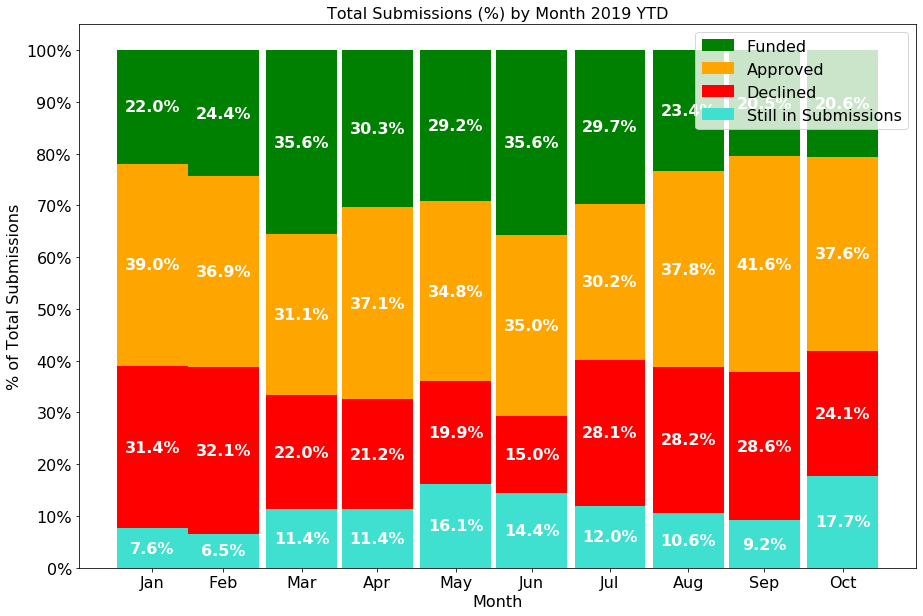

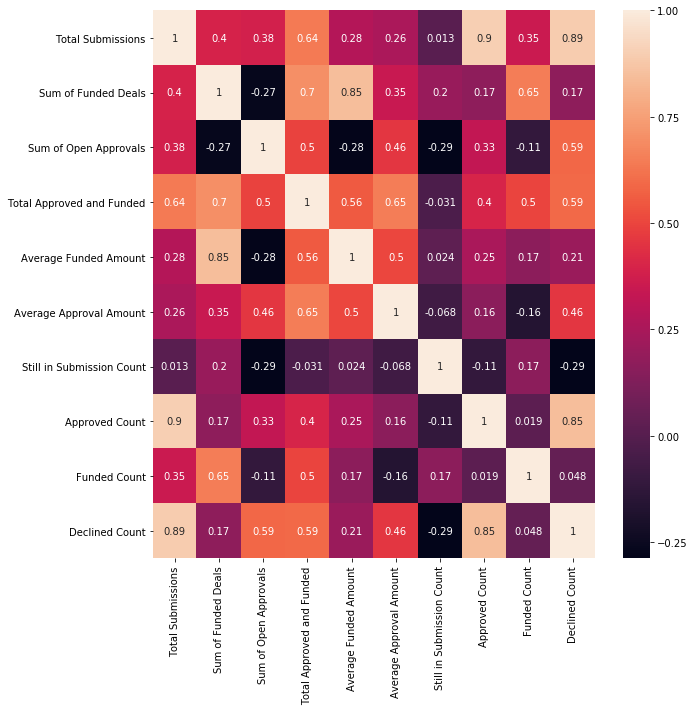

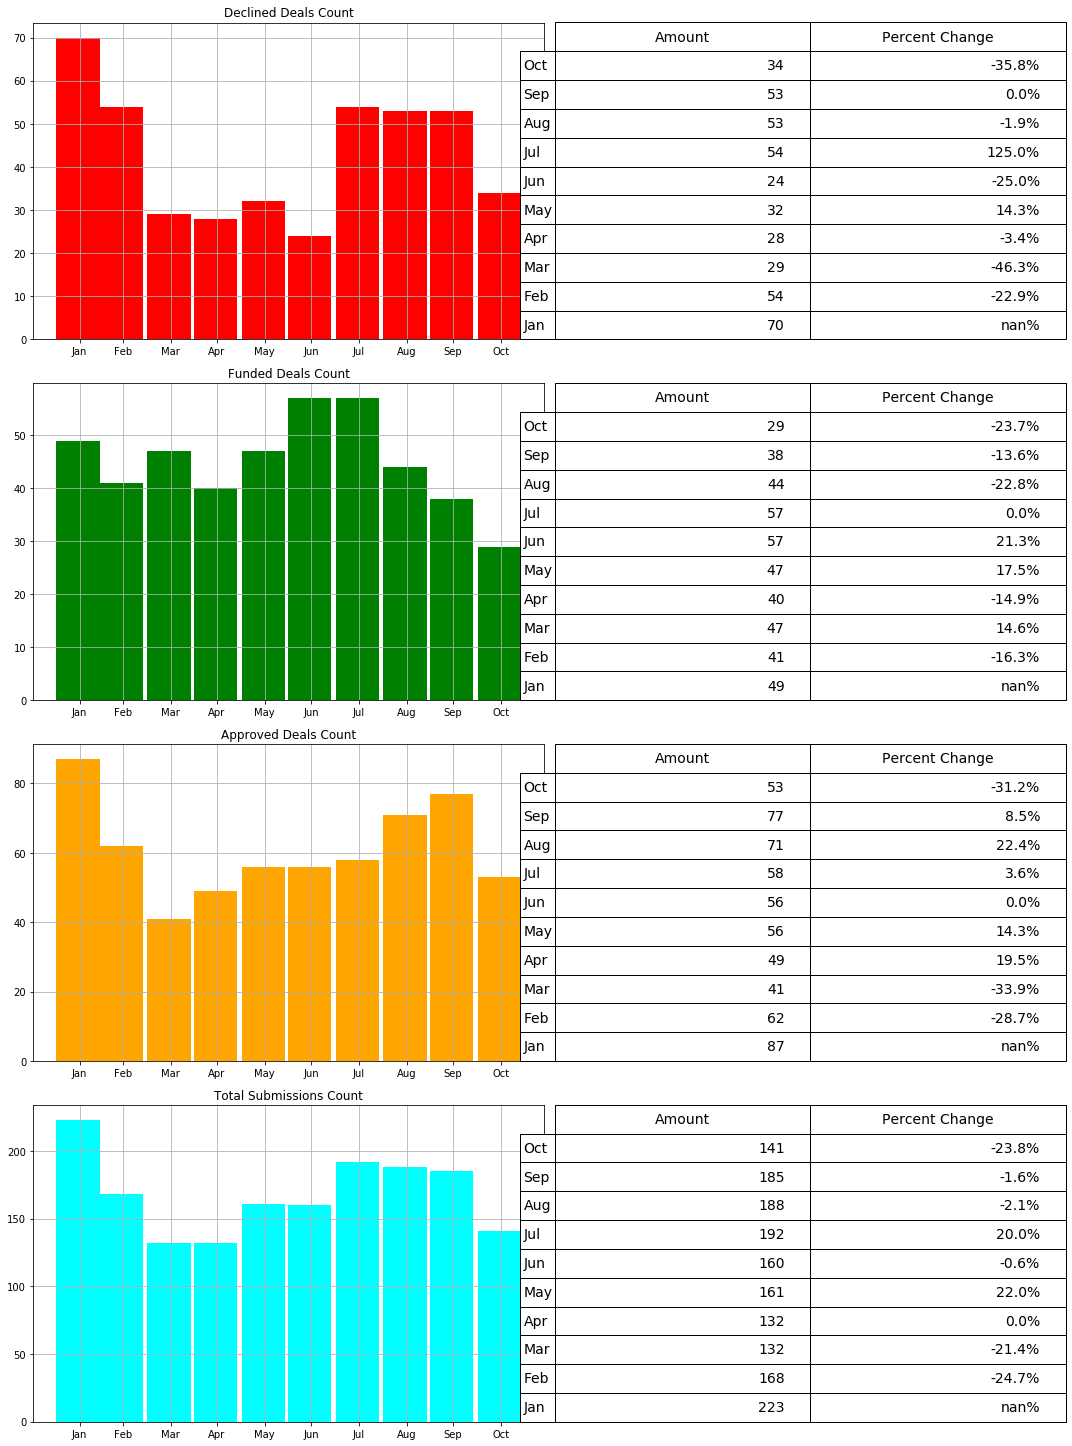

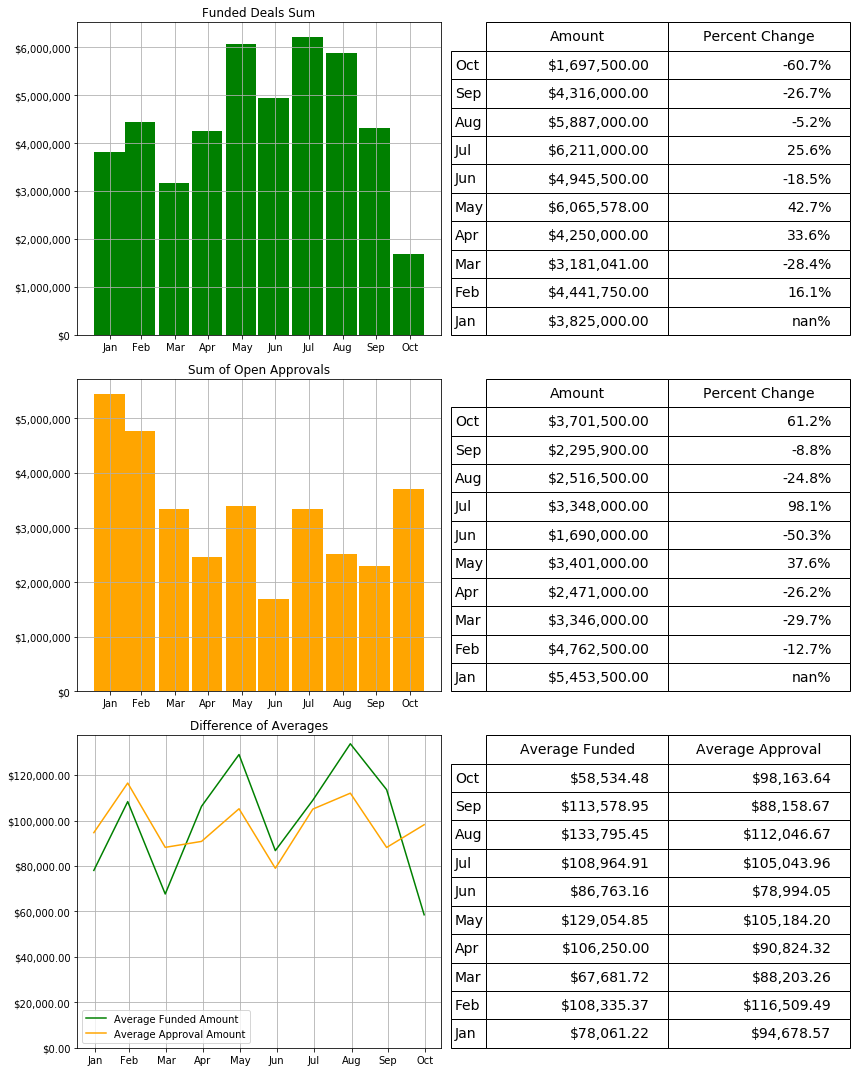

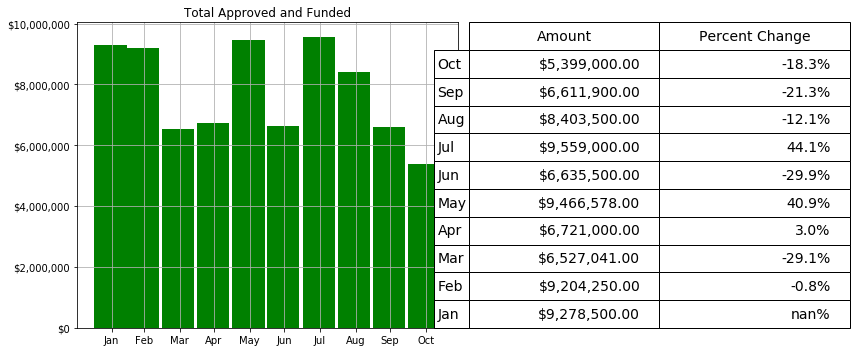

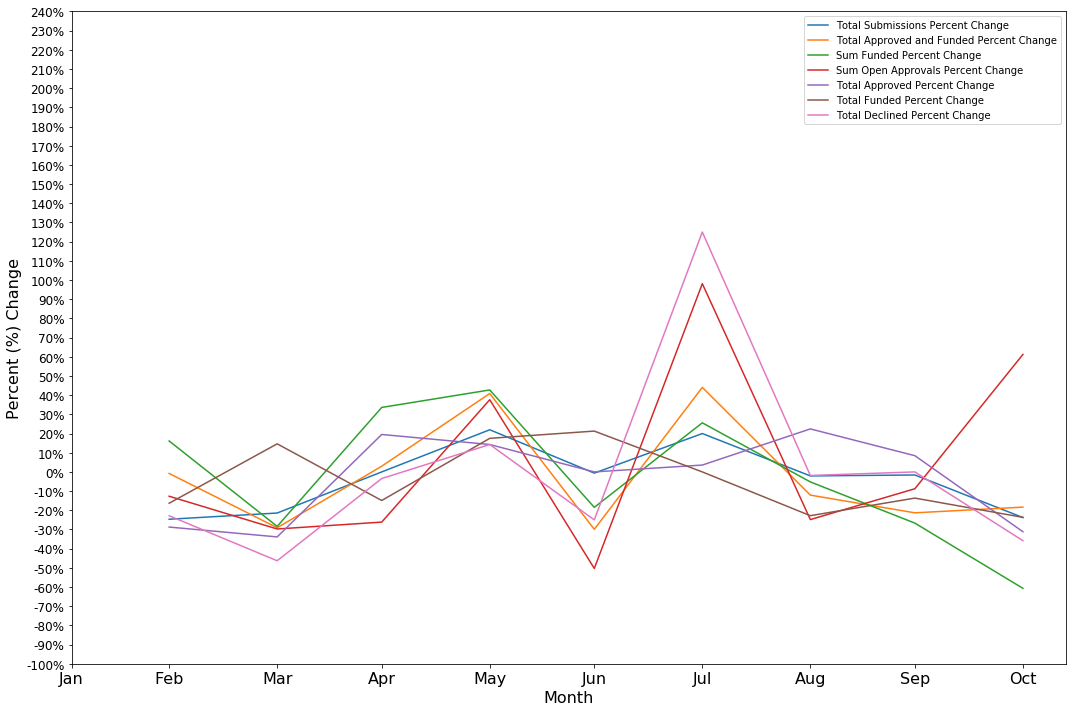

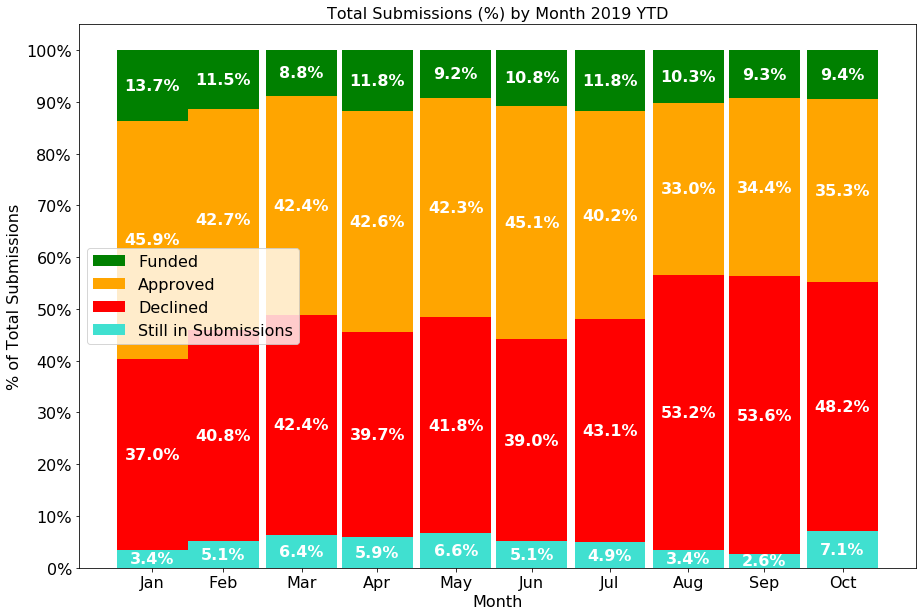

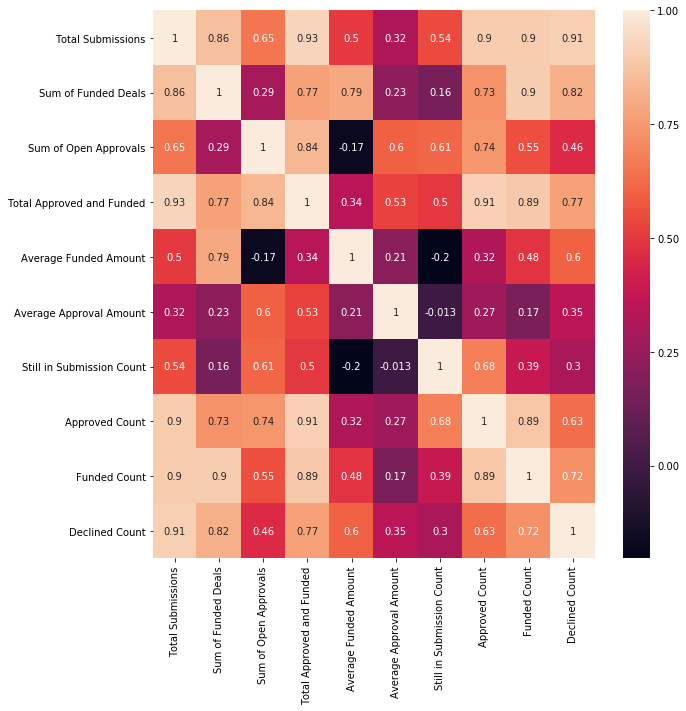

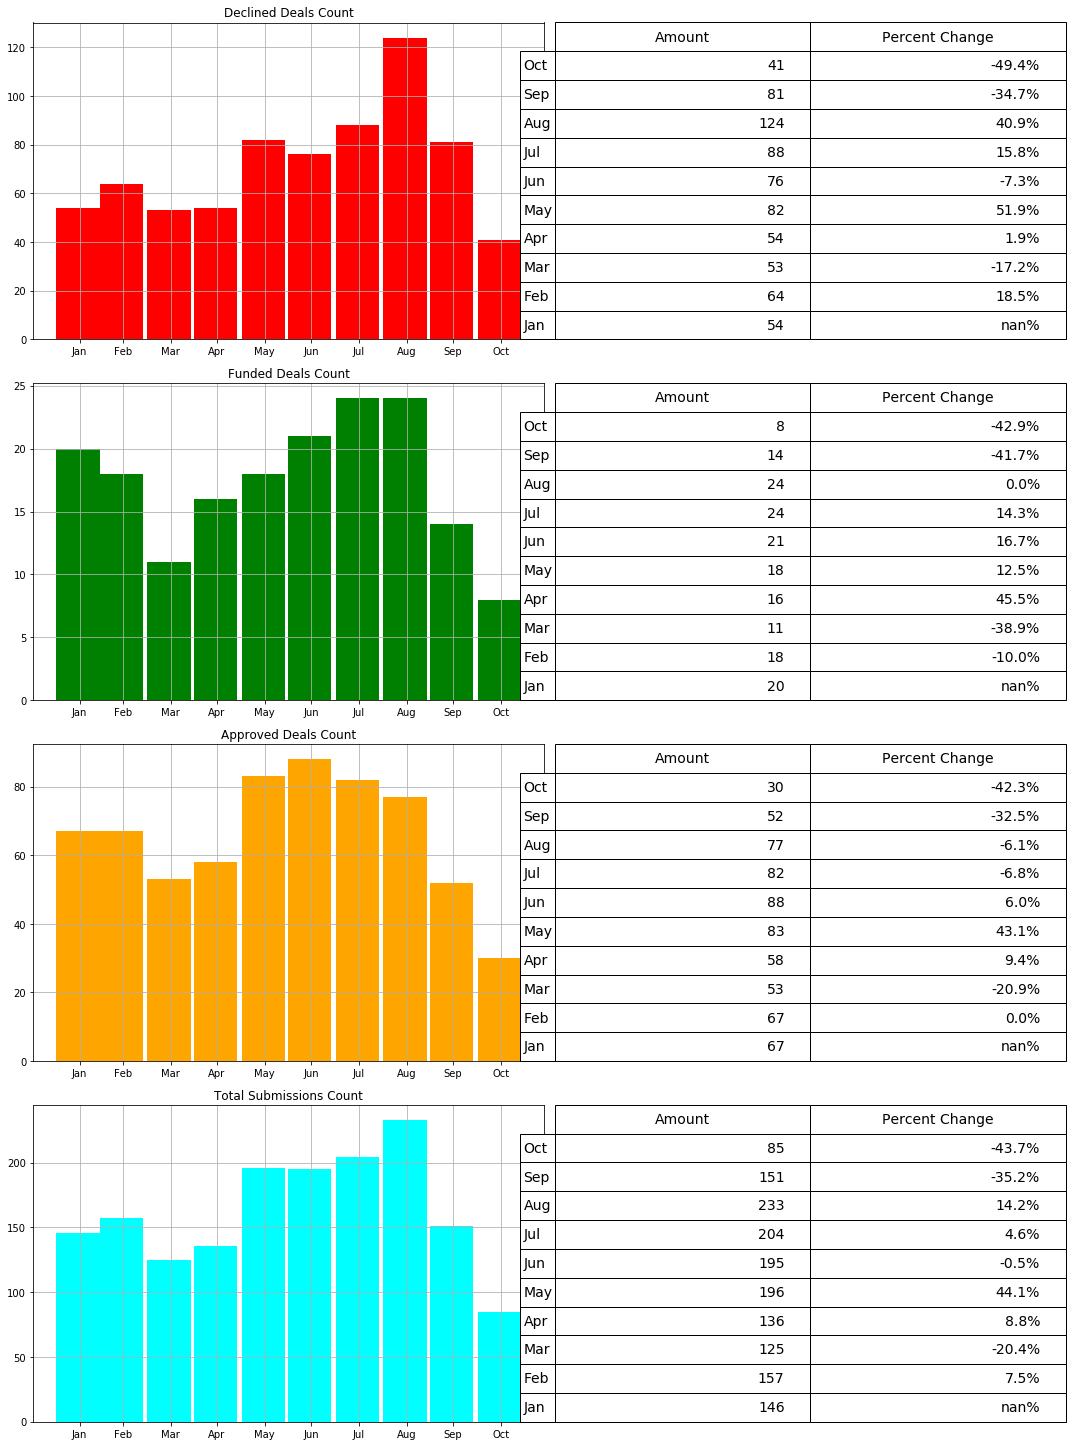

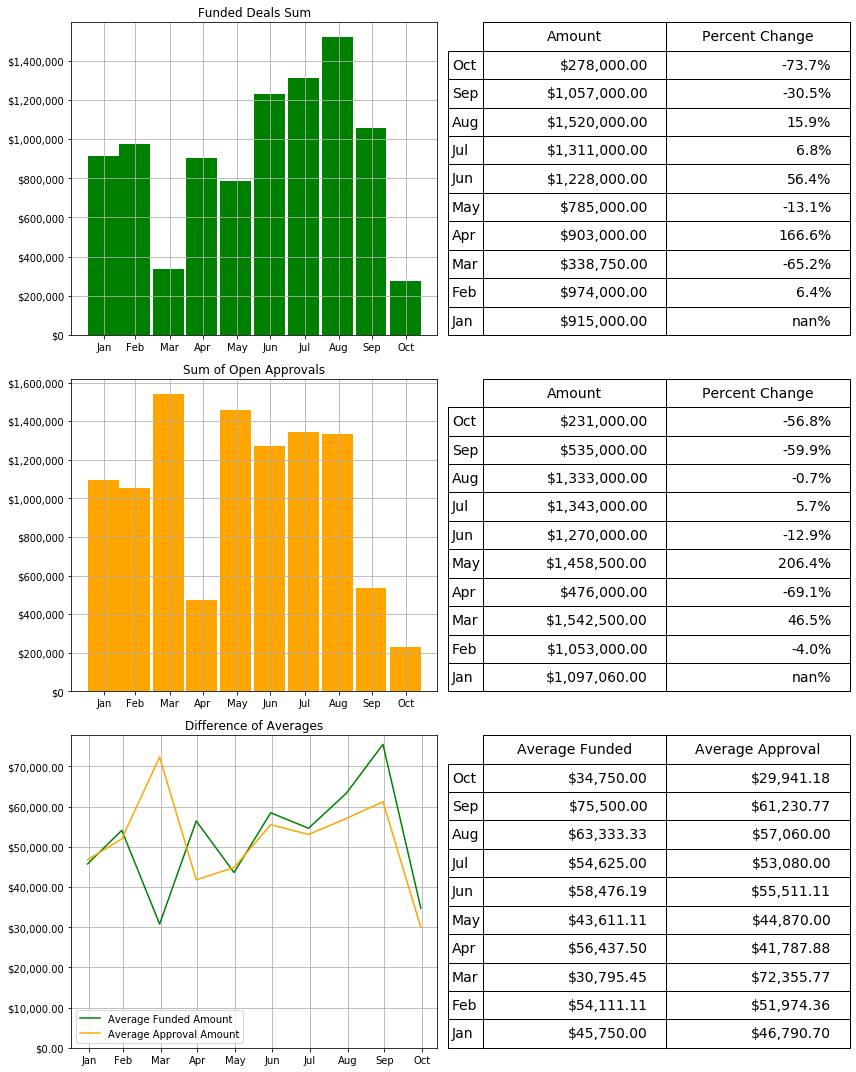

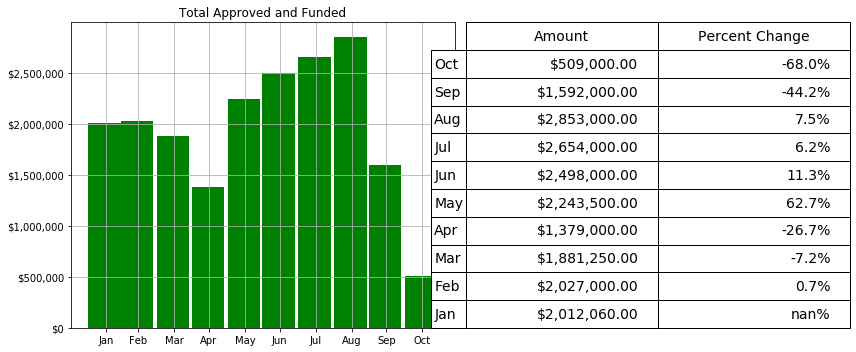

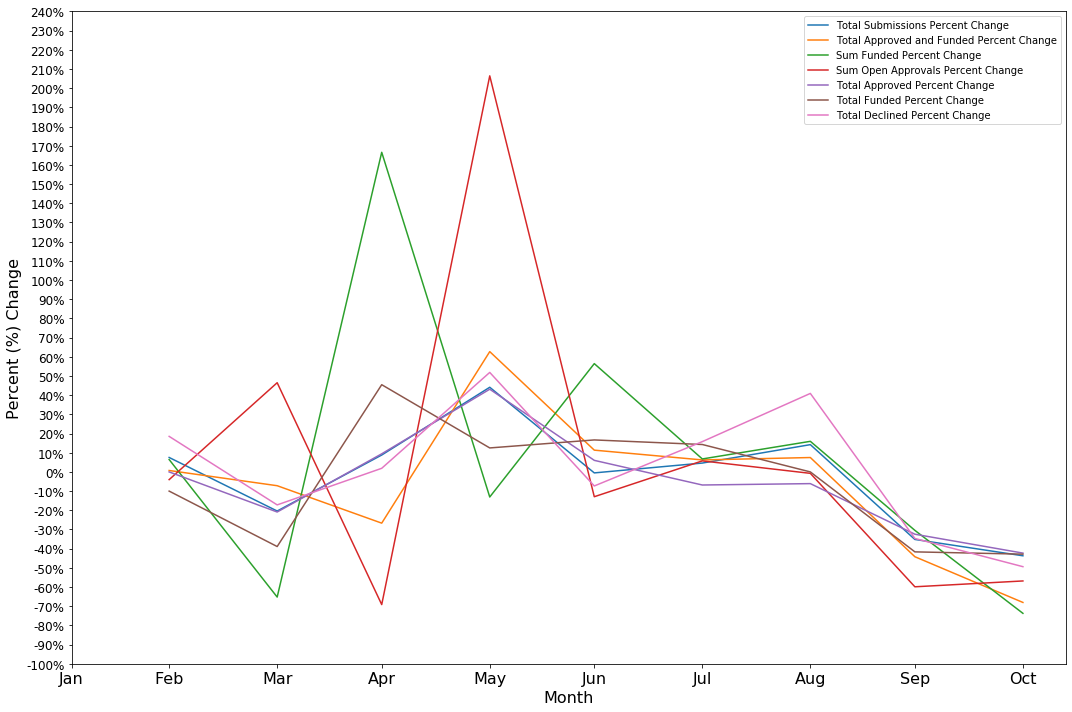

In [71]:
if __name__=="__main__":
    main()